In [8]:
from cycler import V
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import tqdm
import matplotlib.pyplot as plt

from dataset import generate_input, generate_output
from model import UNet
from utils import normalize_image

In [9]:
model_path = 'final_unet_model.pth'
expo = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(channelExponent=3, dropout=0.).to(device)
model.load_state_dict(torch.load(model_path))
criterion = nn.L1Loss()

In [10]:
# Ghia et al. (1982) - Re = 100
reference_ux_RE_100 = {
    128: 1.00000,
    125: 0.84123,
    124: 0.78871,
    123: 0.73722,
    122: 0.68717,
    109: 0.23151,
    94: 0.00332,
    79: -0.13641,
    64: -0.20581,
    58: -0.21090,
    36: -0.15662,
    22: -0.10150,
    13: -0.06434,
    9: -0.04775,
    8: -0.04192,
    7: -0.03717,
    0: 0.00000
}

# Ghia et al. (1982) - Re = 100
reference_uy_RE_100 = {
    128: 0.00000,
    124: -0.05906,
    123: -0.07391,
    122: -0.08864,
    121: -0.10313,
    116: -0.16914,
    110: -0.22445,
    103: -0.24533,
    64: 0.05454,
    30: 0.17527,
    29: 0.17507,
    20: 0.16077,
    12: 0.12317,
    10: 0.10890,
    9: 0.10091,
    8: 0.09233,
    0: 0.00000
}

In [11]:
one_input = normalize_image(generate_input(100, 8.00).reshape(1, 3, 128, 128))
one_input = torch.tensor(one_input, dtype=torch.float32).to(device)

In [12]:
one_output = model(one_input)
one_output = one_output.cpu().detach().numpy().reshape(3, 128, 128)

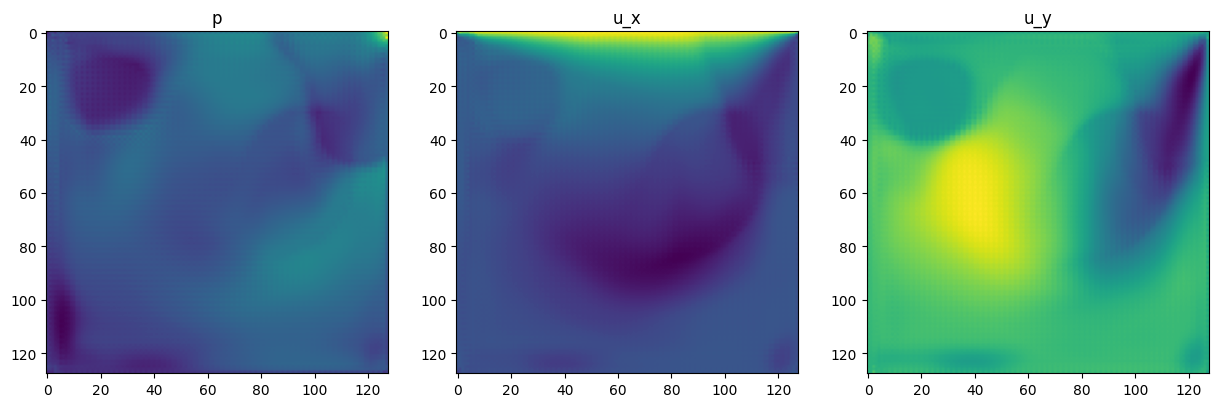

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(one_output[0], cmap='viridis')
axs[0].set_title('p')
axs[1].imshow(one_output[1], cmap='viridis')
axs[1].set_title('u_x')
axs[2].imshow(one_output[2], cmap='viridis')
axs[2].set_title('u_y')
plt.show()

In [14]:
# read array from u_ss.txt and v_ss.txt
u_original = np.loadtxt('../../data_gen_and_prep/data/100.0/u_ss.txt')
v_original = np.loadtxt('../../data_gen_and_prep/data/100.0/v_ss.txt')

u_original.shape, v_original.shape

((128, 128), (128, 128))

In [15]:
u = one_output[1]
v = one_output[2]

u = u * (u_original.max() - u_original.min()) + u_original.min()
v = v * (v_original.max() - v_original.min()) + v_original.min()

In [16]:
# get middle line
u_middle_line = u[:, 64][::-1]
v_middle_line = v[64, :]

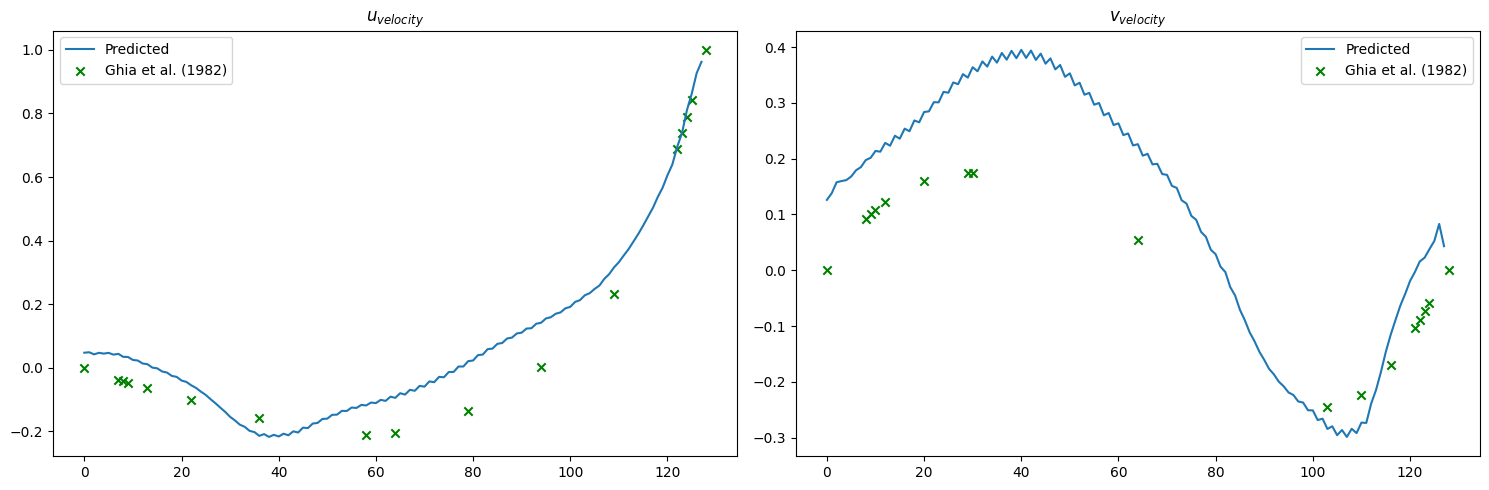

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(u_middle_line, label='Predicted')
ax[0].scatter(reference_ux_RE_100.keys(), reference_ux_RE_100.values(), label='Ghia et al. (1982)', marker='x', color='green')
ax[0].set_title('$u_{velocity}$')
ax[0].legend()
ax[1].plot(v_middle_line, label='Predicted')
ax[1].scatter(reference_uy_RE_100.keys(), reference_uy_RE_100.values(), label='Ghia et al. (1982)', marker='x', color='green')
ax[1].set_title('$v_{velocity}$')
ax[1].legend()

plt.tight_layout()
plt.savefig('ghia_et_al.png')
plt.show()

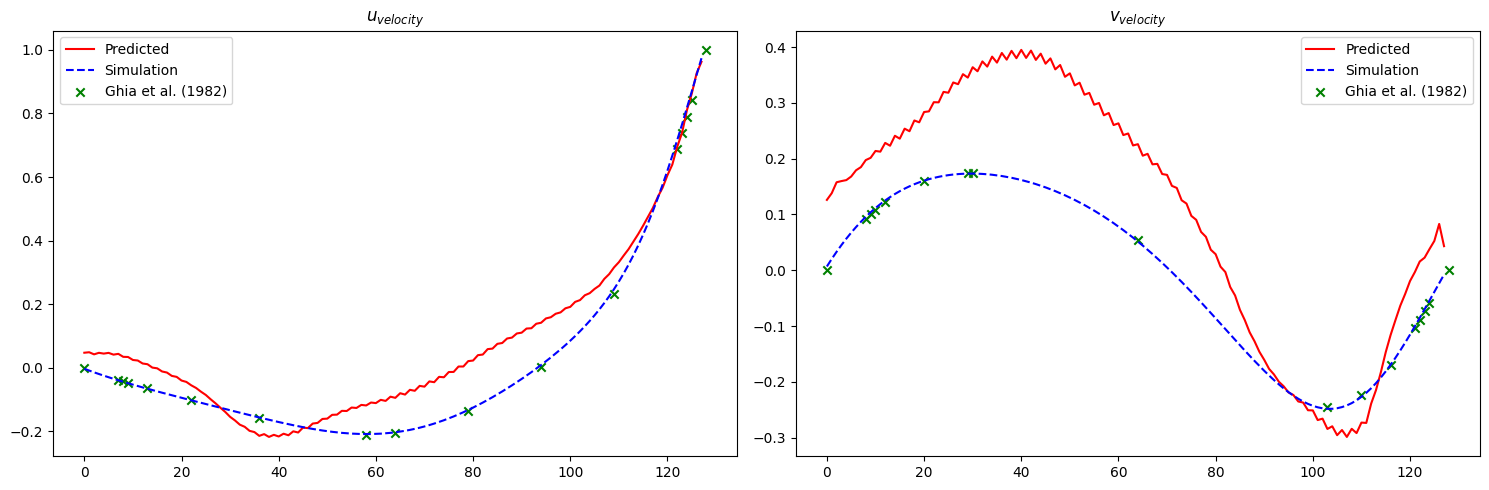

In [18]:
# add the simulation results to the plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(u_middle_line, label='Predicted', color='red')
ax[0].plot(u_original[:, 64][::-1], label='Simulation', color='blue', linestyle='--')
ax[0].scatter(reference_ux_RE_100.keys(), reference_ux_RE_100.values(), label='Ghia et al. (1982)', marker='x', color='green')
ax[0].set_title('$u_{velocity}$')
ax[0].legend()

ax[1].plot(v_middle_line, label='Predicted', color='red')
ax[1].plot(v_original[64, :], label='Simulation', color='blue', linestyle='--')
ax[1].scatter(reference_uy_RE_100.keys(), reference_uy_RE_100.values(), label='Ghia et al. (1982)', marker='x', color='green')
ax[1].set_title('$v_{velocity}$')
ax[1].legend()

plt.tight_layout()
plt.savefig('ghia_et_al_with_simulation.png')
plt.show()